## Imports

In [ ]:
import json
import librosa, librosa.display
import matplotlib.pyplot as plt
import keras 
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras.models import Model, load_model
from keras import optimizers
from keras import backend as K
from sklearn.metrics import f1_score
from sklearn import svm
import random

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## Fetch data from json transcript

In [ ]:
f = open('/content/drive/MyDrive/Sarcasm/Dataset/mustard/transcript.json',) 
  
# returns JSON object as  
# a dictionary 
data_text = json.load(f) 
data = pd.read_csv('new_tra_sarc.csv')
data_non_sarc = pd.read_csv('new_tra_non_sarc.csv')

In [ ]:
name_list = []
for i in data['name']:
  name_list.append(i)

name_list_ns = []
for i in data_non_sarc['name']:
  name_list_ns.append(i)

# Audio

## Fn define

### Create MFCCs

In [ ]:
def create_MFCC(data):
  hop_length = 512 # in num. of samples
  n_fft = 2048 # window in num. of samples

  X = []
  y = []

  #counter 
  c = 0
  c2 = 0
  for i in data['name']:
    f = "/content/drive/MyDrive/Sarcasm/Dataset/mustard/utterance_audio/"+str(i)+".wav"
    # load audio file with Librosa
    signal, sample_rate = librosa.load(f, sr=22050)
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    X.append(MFCCs)
    c += 1
    if(c==10):
      print(c2)
      c2 += 1
      c= 0
  return(X)

### Slice MFCCs

In [ ]:
def slice_MFCC(data, X):
  l = data['name']
  X_seg = []
  y_seg = []
  win_count_train = []
  for i in range(len(X)):
    s = 0
    e = s+46  #filter size
    p = 1
    x = X[i].T
    win_count_train.append(0)
    while(e<x.shape[0]):
      win_count_train[-1] += 1
      X_seg.append(np.array(x[s:e]))
      if( int(data[data['name']==l[i]]['start_win']) <=p and int(data[data['name']==l[i]]['end_win']) >=p):
        y_seg.append(1)
      else:
        y_seg.append(0)
      s,e,p = e, e+46, p+1
  return(X_seg, y_seg, win_count_train)

### RNN Model

In [ ]:
def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

In [ ]:
model = build_model((46,13))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 46, 64)            19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 57,282
Trainable params: 57,282
Non-trainable params: 0
_________________________________________________________________


## Fn call sarc

In [ ]:
X = create_MFCC(data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array([i for i in range(345)]), np.array([0 for i in range(345)]), test_size=0.2, random_state=55)

X_tr = [X[i] for i in X_train]
X_te = [X[i] for i in X_test]

name1 = [name_list[i] for i in X_train]
name2 = [name_list[i] for i in X_test]
new_name_list = name1+name2

X_seg, y_seg, win_count_train = slice_MFCC(data, X_tr)
X_test, y_test, win_count_test = slice_MFCC(data, X_te)

In [ ]:
y_seg.count(0)

479

In [ ]:
#history = model.fit(np.array(X_seg), np.array(y_seg),  batch_size=5, epochs=10)
model = keras.models.load_model('/content/F1-38.h5')

In [ ]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test), verbose=2)
print('\nTest accuracy:', test_acc)

10/10 - 1s - loss: 0.6878 - accuracy: 0.5938

Test accuracy: 0.59375


In [ ]:
l = model.predict(np.array(X_test))
print(len(l), sum(win_count_train))
a = []
for i in range(len(l)):
  if(l[i][0]>=l[i][1]):
    a.append(0)
  else:
    a.append(1)

confusion_matrix(np.array(y_test), a)

320 1383


array([[171,  32],
       [ 98,  19]])

In [ ]:
model.save('F1-38.h5')

### Multiple models

In [ ]:
import random
TA = []
F1 = []
CM = []
II = [74, 68, 2, 29, 27, 73, 48, 98, 65, 88]
for kz in range(10):
  iki = II[kz]#random.randint(1,100)
  #II.append(iki)
  X_train, X_test, y_train, y_test = train_test_split(np.array([i for i in range(345)]), np.array([0 for i in range(345)]), test_size=0.2, random_state=iki)

  X_tr = [X[i] for i in X_train]
  X_te = [X[i] for i in X_test]
  X_seg, y_seg, win_count_train = slice_MFCC(data, X_tr)
  X_test, y_test, win_count_test = slice_MFCC(data, X_te)

  history = model.fit(np.array(X_seg), np.array(y_seg),  batch_size=5, epochs=10)

  test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test), verbose=2)
  TA.append(test_acc)

  l = model.predict(np.array(X_test))
  print(len(l), sum(win_count_train))
  a = []
  for i in range(len(l)):
    if(l[i][0]>=l[i][1]):
      a.append(0)
    else:
      a.append(1)

  CM.append(confusion_matrix(np.array(y_test), a))

  from sklearn.metrics import f1_score
  F1.append(f1_score(np.array(y_test), a))

Epoch 1/10
271/271 [==============================] - 12s 36ms/step - loss: 0.7637 - accuracy: 0.6109
Epoch 2/10
271/271 [==============================] - 10s 36ms/step - loss: 0.6267 - accuracy: 0.6516
Epoch 3/10
271/271 [==============================] - 10s 36ms/step - loss: 0.5908 - accuracy: 0.6805
Epoch 4/10
271/271 [==============================] - 10s 36ms/step - loss: 0.5674 - accuracy: 0.6827
Epoch 5/10
271/271 [==============================] - 10s 36ms/step - loss: 0.5383 - accuracy: 0.7130
Epoch 6/10
271/271 [==============================] - 10s 36ms/step - loss: 0.5182 - accuracy: 0.7234
Epoch 7/10
271/271 [==============================] - 10s 36ms/step - loss: 0.4992 - accuracy: 0.7389
Epoch 8/10
271/271 [==============================] - 10s 36ms/step - loss: 0.4721 - accuracy: 0.7537
Epoch 9/10
271/271 [==============================] - 10s 36ms/step - loss: 0.4467 - accuracy: 0.7692
Epoch 10/10
271/271 [==============================] - 10s 36ms/step - loss: 0.426

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([j for j in range(10)] , F1, color = 'b', width = 0.25)
ax.bar([j+0.25 for j in range(10)] , TA, color = 'g', width = 0.25)
plt.show()

In [ ]:
II

In [ ]:
for i in range(10):
  print(TA[i], F1[i], CM[i])

### Feature Conversion

In [ ]:
matrix_size = model.layers[-2].output.shape[1]
print(matrix_size)
new_model = Model(model.inputs, model.layers[-2].output)

64


In [ ]:
(new_model.predict(np.array(X_test)[:1]))

array([[0.        , 0.12855256, 0.        , 0.43094003, 0.79551524,
        0.8290689 , 1.0363905 , 0.        , 1.2199714 , 0.        ,
        0.        , 0.        , 0.20833789, 0.        , 0.        ,
        0.        , 0.16885601, 0.        , 0.9716392 , 0.64020914,
        0.        , 0.08212314, 0.        , 0.5561128 , 0.45482635,
        0.        , 0.08716213, 0.        , 0.        , 0.6190659 ,
        0.0805793 , 0.        , 1.3854859 , 0.        , 0.        ,
        0.        , 1.3304223 , 0.68982404, 0.475102  , 0.19912429,
        1.078324  , 0.        , 0.02208611, 1.3275652 , 0.        ,
        1.0927919 , 0.01053949, 0.77340204, 0.        , 0.        ,
        0.        , 1.038279  , 0.8971938 , 0.        , 0.        ,
        1.4659464 , 0.68385196, 0.76231766, 0.        , 0.        ,
        0.        , 1.7066183 , 0.        , 0.333365  ]], dtype=float32)

In [ ]:
matrix_size = model.layers[-2].output.shape[1]
new_model = Model(model.inputs, model.layers[-2].output)
lT = new_model.predict(np.array(X_seg))
lt = new_model.predict(np.array(X_test))

In [ ]:
new_out_train = []
new_y_train = []
j = 0
for i in win_count_train:
  new_out_train.append(np.mean(np.array(lT[j:j+i]), axis=0))
  j += i
  new_y_train.append(1)

new_out_test = []
j = 0
for i in win_count_test:
  new_out_test.append(np.mean(np.array(lt[j:j+i]), axis=0))
  j += i

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
train_X_sarc = new_out_train+new_out_test
train_y_sarc = [1 for i in range(len(train_X_sarc))]

## for non sarc

In [ ]:
X_ns = create_MFCC(data_non_sarc)

X_seg_ns, y_seg_ns, win_count_train_ns = slice_MFCC(data_non_sarc, X_ns)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [ ]:
lT_ns = new_model.predict(np.array(X_seg_ns))

In [ ]:
new_out_ns = []
j = 0
for i in win_count_train_ns:
  new_out_ns.append(np.mean(np.array(lT_ns[j:j+i]), axis=0))
  j += i

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
train_X_non_sarc = new_out_ns
train_y_non_sarc = [0 for i in range(len(train_X_non_sarc))]

## Final input for multimodel

In [ ]:
X_audio = train_X_sarc+train_X_non_sarc
y_audio = train_y_sarc+train_y_non_sarc

# Text

In [ ]:
text = []
out = []

In [ ]:
d = {True:1, False:0}
for i in data['name']:
  text.append(data_text[i]['utterance'])
  out.append(d[data_text[i]['sarcasm']])

for i in data_non_sarc['name']:
  text.append(data_text[i]['utterance'])
  out.append(d[data_text[i]['sarcasm']])

In [ ]:
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
print(vocab_size)

2036


In [ ]:
train = t.texts_to_sequences(text)

In [ ]:
lengths = []

for doc in train:
    lengths.append(len(doc))

In [ ]:
np.percentile(lengths, 99.9)

56.04300000000046

In [ ]:
max_length = 60
padded_comments_train = pad_sequences(train, maxlen=max_length, padding='post')

In [ ]:
y_train = to_categorical(out, num_classes=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_comments_train, y_train, test_size=0.2, random_state=42) # rand= 15

In [ ]:
w2v_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Sarcasm/Dataset/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

(2036, 300)

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Model 1

In [ ]:
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)

lstm_layer = Bidirectional(LSTM(128,return_sequences=True))(max_2)

flatten = Flatten()(lstm_layer)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 60)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 300)           610800    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 57, 50)            60050     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 28, 50)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 100)           15100     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 13, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 13, 256)           2344

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(X_train, y_train,  batch_size=64, epochs=5, verbose=1)

Epoch 1/5
9/9 [==============================] - 5s 100ms/step - loss: 0.6933 - f1_m: 0.5166 - acc: 0.5201
Epoch 2/5
9/9 [==============================] - 1s 101ms/step - loss: 0.6916 - f1_m: 0.5474 - acc: 0.5476
Epoch 3/5
9/9 [==============================] - 1s 99ms/step - loss: 0.6905 - f1_m: 0.5479 - acc: 0.5476
Epoch 4/5
9/9 [==============================] - 1s 99ms/step - loss: 0.6857 - f1_m: 0.5799 - acc: 0.5807
Epoch 5/5
9/9 [==============================] - 1s 98ms/step - loss: 0.6843 - f1_m: 0.5847 - acc: 0.5833


In [ ]:
score_1 = model_01.evaluate(X_test, y_test)
score_1

5/5 [==============================] - 1s 17ms/step - loss: 0.6812 - f1_m: 0.6412 - acc: 0.6159


[0.681247353553772, 0.64124995470047, 0.6159420013427734]

In [ ]:
y_pred = model_01.predict(X_test)
y_true = y_test
print(recall_m(y_true, y_pred), precision_m(y_true, y_pred), f1_m(y_true, y_pred))

tf.Tensor(0.615942, shape=(), dtype=float32) tf.Tensor(0.615942, shape=(), dtype=float32) tf.Tensor(0.61594194, shape=(), dtype=float32)


In [ ]:
yyp = []
for i in y_pred:
  if(i[0]>i[1]):
    yyp.append(0)
  else:
    yyp.append(1)

yy = []
for i in y_true:
  if(i[0]>i[1]):
    yy.append(0)
  else:
    yy.append(1)

In [ ]:
precision_score(yy, yyp), recall_score(yy, yyp), f1_score(yy, yyp), accuracy_score(yy, yyp)

(0.675, 0.6666666666666666, 0.670807453416149, 0.6159420289855072)

In [ ]:
y = []
Y = []
for i in range(len(y_test)):
  if(y_test[i][0] >= y_test[i][1]):
    Y.append(0)
  else:
    Y.append(1)
  if(y_pred[i][0] >= y_pred[i][1]):
    y.append(0)
  else:
    y.append(1)

In [ ]:
confusion_matrix(Y, y)

array([[31, 26],
       [27, 54]])

## Feature Conversion

In [ ]:
matrix_size_t = model_01.layers[-2].output.shape[1]
print(matrix_size_t)
new_model_t = Model(model_01.inputs, model_01.layers[-2].output)

100


In [ ]:
X_text_train = new_model_t.predict(np.array(X_train))
X_text_test = new_model_t.predict(np.array(X_test))

# Combine

In [ ]:
final_name_list = new_name_list+name_list_ns

In [ ]:
flist1, flist2, svavs, sbbxb = train_test_split(final_name_list, [0 for i in range(690)], test_size=0.2, random_state=42)
flist = flist1+flist2
flist = np.array(flist)

In [ ]:
X_audio_train, X_audio_test, y_final_train, y_final_test = train_test_split(X_audio, y_audio, test_size=0.2, random_state=42)

### Hybrid Model

#### code

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neural_network import MLPClassifier

In [ ]:
from sklearn.model_selection import KFold

X_final_train = np.concatenate((X_text_train, X_audio_train), axis=1)
X_final_test = np.concatenate((X_text_test, X_audio_test), axis=1)

final_X_combine = np.concatenate((X_final_train,X_final_test), axis=0)
final_X_audio = np.concatenate((X_audio_train,X_audio_test), axis=0)
final_X_text = np.concatenate((X_text_train,X_text_test), axis=0)
final_Y = np.concatenate((y_final_train,y_final_test), axis=0)

kf = KFold(n_splits=5, shuffle=True)

TAC = [[],[],[],[],[]]
F1C = [[],[],[],[],[]]
PRC = [[],[],[],[],[]]
RLC = [[],[],[],[],[]]

TAA = []
F1A = []
PRA = []
RLA = []

TAT = []
F1T = []
PRT = []
RLT = []

ctaftt = []
ctattf = []
ctaftf = []
for train_index, test_index in kf.split(final_X_combine):
  list_tr, list_te = flist[train_index], flist[test_index]

  kfX_train_combine, kfX_test_combine = final_X_combine[train_index], final_X_combine[test_index]
  kfy_train, kfy_test = final_Y[train_index], final_Y[test_index]

  dfT = pd.DataFrame(kfX_train_combine)
  dft = pd.DataFrame(kfX_test_combine)

  dfT = dfT.fillna(0)
  dft = dft.fillna(0)

  'svm'
  clf1 = svm.SVC()
  clf1.fit(dfT, kfy_train)

  TAC[0].append(clf1.score(dft,kfy_test))
  y_final_pred_1 = clf1.predict(dft)
  F1C[0].append(f1_score(y_final_pred_1, kfy_test))
  PRC[0].append(precision_score(y_final_pred_1, kfy_test))
  RLC[0].append(recall_score(y_final_pred_1, kfy_test))

  'log_reg'
  clf2 = LogisticRegression(random_state=0).fit(dfT, kfy_train)

  TAC[1].append(clf2.score(dft,kfy_test))
  y_final_pred_1 = clf2.predict(dft)
  F1C[1].append(f1_score(y_final_pred_1, kfy_test))
  PRC[1].append(precision_score(y_final_pred_1, kfy_test))
  RLC[1].append(recall_score(y_final_pred_1, kfy_test))

  'naive_bayes'
  clf3 = GaussianNB()
  clf3.fit(dfT, kfy_train)

  TAC[2].append(clf3.score(dft,kfy_test))
  y_final_pred_1 = clf3.predict(dft)
  F1C[2].append(f1_score(y_final_pred_1, kfy_test))
  PRC[2].append(precision_score(y_final_pred_1, kfy_test))
  RLC[2].append(recall_score(y_final_pred_1, kfy_test))

  'tree'
  clf4 = tree.DecisionTreeClassifier()
  clf4.fit(dfT, kfy_train)

  TAC[3].append(clf4.score(dft,kfy_test))
  y_final_pred_1 = clf4.predict(dft)
  F1C[3].append(f1_score(y_final_pred_1, kfy_test))
  PRC[3].append(precision_score(y_final_pred_1, kfy_test))
  RLC[3].append(recall_score(y_final_pred_1, kfy_test))

  'mlp'
  clf5 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  clf5.fit(dfT, kfy_train)

  TAC[4].append(clf5.score(dft,kfy_test))
  y_final_pred_1 = clf5.predict(dft)
  F1C[4].append(f1_score(y_final_pred_1, kfy_test))
  PRC[4].append(precision_score(y_final_pred_1, kfy_test))
  RLC[4].append(recall_score(y_final_pred_1, kfy_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

#### results

In [ ]:
print('svm')
print("{0:0.4f}".format(np.mean(F1C[0])), "{0:0.4f}".format(np.mean(TAC[0])), "{0:0.4f}".format(np.mean(PRC[0])), "{0:0.4f}".format(np.mean(RLC[0])))
print('log_reg')
print("{0:0.4f}".format(np.mean(F1C[1])), "{0:0.4f}".format(np.mean(TAC[1])), "{0:0.4f}".format(np.mean(PRC[1])), "{0:0.4f}".format(np.mean(RLC[1])))
print('bayes')
print("{0:0.4f}".format(np.mean(F1C[2])), "{0:0.4f}".format(np.mean(TAC[2])), "{0:0.4f}".format(np.mean(PRC[2])), "{0:0.4f}".format(np.mean(RLC[2])))
print('tree')
print("{0:0.4f}".format(np.mean(F1C[3])), "{0:0.4f}".format(np.mean(TAC[3])), "{0:0.4f}".format(np.mean(PRC[3])), "{0:0.4f}".format(np.mean(RLC[3])))
print('mlp')
print("{0:0.4f}".format(np.mean(F1C[4])), "{0:0.4f}".format(np.mean(TAC[4])), "{0:0.4f}".format(np.mean(PRC[4])), "{0:0.4f}".format(np.mean(RLC[4])))

svm
0.6901 0.6710 0.7326 0.6539
log_reg
0.6664 0.6638 0.6724 0.6649
bayes
0.6477 0.6333 0.6773 0.6223
tree
0.5609 0.5652 0.5544 0.5705
mlp
0.6127 0.6072 0.6245 0.6070


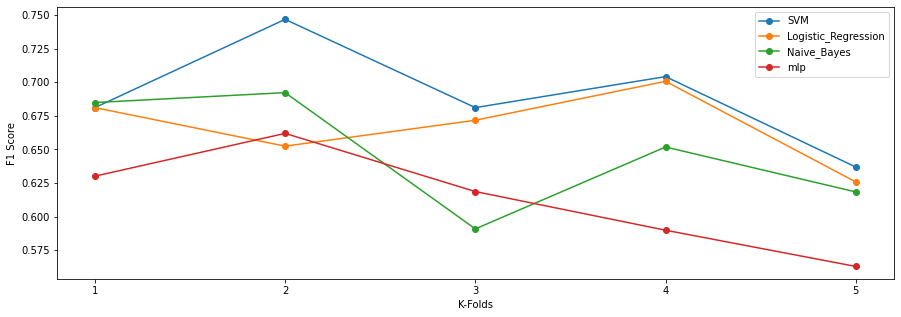

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15,5))

plt.xlabel('K-Folds')
plt.ylabel('F1 Score')

plt.xticks(ticks=[1,2,3,4,5])

plt.plot([1,2,3,4,5], F1C[0], marker='o', label='SVM')
plt.plot([1,2,3,4,5], F1C[1], marker='o', label='Logistic_Regression')
plt.plot([1,2,3,4,5], F1C[2], marker='o', label='Naive_Bayes')
#plt.plot([1,2,3,4,5], F1C[3], marker='o', label='tree')
plt.plot([1,2,3,4,5], F1C[4], marker='o', label='mlp')

plt.legend()
plt.show()

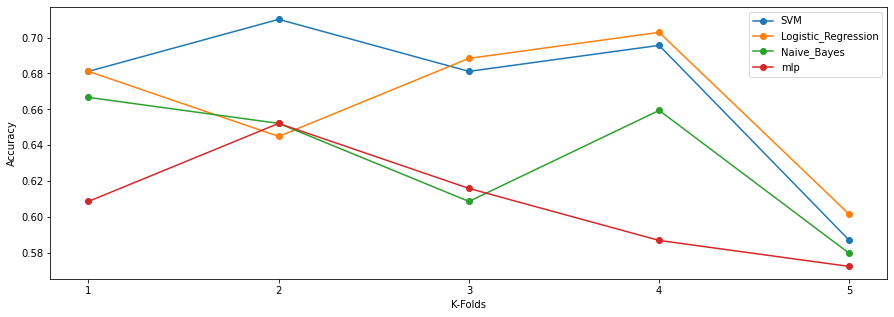

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15,5))

plt.xlabel('K-Folds')
plt.ylabel('Accuracy')

plt.xticks(ticks=[1,2,3,4,5])

plt.plot([1,2,3,4,5], TAC[0], marker='o', label='SVM')
plt.plot([1,2,3,4,5], TAC[1], marker='o', label='Logistic_Regression')
plt.plot([1,2,3,4,5], TAC[2], marker='o', label='Naive_Bayes')
#plt.plot([1,2,3,4,5], TAC[3], marker='o', label='tree')
plt.plot([1,2,3,4,5], TAC[4], marker='o', label='mlp')

plt.legend()
plt.show()

## Only audio

In [ ]:
X_final_train = X_audio_train
X_final_test = X_audio_test

### K Fold

In [ ]:
from sklearn.model_selection import KFold
final_X = np.concatenate((X_final_train,X_final_test), axis=0)
final_Y = np.concatenate((y_final_train,y_final_test), axis=0)
kf = KFold(n_splits=5, shuffle=True)
TA = []
F1 = []
PR = []
RL = []
for train_index, test_index in kf.split(final_X):
  kfX_train, kfX_test = final_X[train_index], final_X[test_index]
  kfy_train, kfy_test = final_Y[train_index], final_Y[test_index]
  dfT = pd.DataFrame(kfX_train)
  dft = pd.DataFrame(kfX_test)
  dfT = dfT.fillna(0)
  dft = dft.fillna(0)
  clf1 = svm.SVC()
  clf1.fit(dfT, kfy_train)

  TA.append(clf1.score(dft,kfy_test))
  y_final_pred_1 = clf1.predict(dft)
  F1.append(f1_score(y_final_pred_1, kfy_test))
  PR.append(precision_score(y_final_pred_1, kfy_test))
  RL.append(recall_score(y_final_pred_1, kfy_test))

In [ ]:
max(F1), np.mean(F1), max(TA), np.mean(TA)

(0.75, 0.6923759416972768, 0.7246376811594203, 0.6753623188405797)

In [ ]:
max(F1), np.mean(F1), max(TA), np.mean(TA)

(0.75, 0.6923759416972768, 0.7246376811594203, 0.6753623188405797)

### Multiple Model

In [ ]:
final_X = np.concatenate((X_final_train,X_final_test), axis=0)
final_Y = np.concatenate((y_final_train,y_final_test), axis=0)
II = []
PR = []
RCL = []
II = [729,
 125,
 975,
 948,
 296,
 921,
 414,
 85,
 31,
 792,
 87,
 259,
 431,
 931,
 105,
 237,
 577,
 120,
 523,
 710,
 894,
 395,
 682,
 144,
 5,
 670,
 652,
 413,
 553,
 452,
 156,
 619,
 158,
 121,
 833,
 974,
 649,
 966,
 128,
 719,
 346,
 210,
 707,
 203,
 955,
 128,
 875,
 427,
 427,
 423,
 977,
 8,
 999,
 395,
 1000,
 499,
 397,
 839,
 516,
 7,
 494,
 396,
 161,
 503,
 577,
 484,
 555,
 442,
 731,
 408,
 70,
 132,
 898,
 396,
 225,
 543,
 377,
 653,
 888,
 549,
 928,
 685,
 457,
 509,
 860,
 6,
 316,
 987,
 530,
 208,
 408,
 673,
 423,
 638,
 581,
 387,
 258,
 91,
 831,
 198]
TA = []
F1 = []
for ijiki in range(100):
  iki = II[ijiki]#random.randint(1,1000)
  #II.append(iki)

  X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(final_X, final_Y, test_size=0.2, random_state=iki)

  dfT = pd.DataFrame(X_final_train)
  dft = pd.DataFrame(X_final_test)

  dfT = dfT.fillna(0)
  dft = dft.fillna(0)

  clf1 = svm.SVC()
  clf1.fit(dfT, y_final_train)

  y_final_pred_1 = clf1.predict(dft)

  TA.append(clf1.score(dft,y_final_test))
  y_pred = clf1.predict(dft)
  PR.append(precision_score(y_final_test, y_pred))
  RCL.append(recall_score(y_final_test, y_pred))
  F1.append(f1_score(y_final_pred_1, y_final_test))

In [ ]:
np.mean(F1), np.mean(TA), np.mean(PR), np.mean(RCL)

(0.5299308339032415,
 0.4901449275362319,
 0.4962042939228916,
 0.5881047839819148)

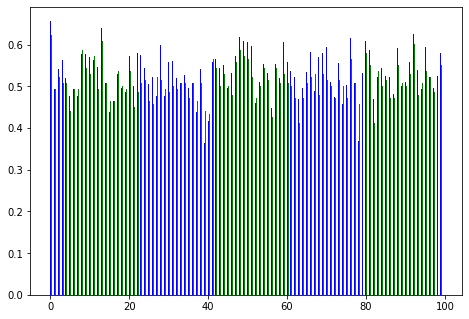

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([j for j in range(100)] , F1, color = 'b', width = 0.25)
ax.bar([j+0.25 for j in range(100)] , TA, color = 'g', width = 0.25)
plt.show()

### Regular

In [ ]:
import pandas as pd

dfT = pd.DataFrame(X_final_train)
dft = pd.DataFrame(X_final_test)

In [ ]:
dfT = dfT.fillna(0)
dft = dft.fillna(0)

In [ ]:
from sklearn import svm

clf1 = svm.SVC()
clf1.fit(dfT, y_final_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_final_pred_1 = clf1.predict(dft)

In [ ]:
clf1.score(dft,y_final_test)

0.7318840579710145

In [ ]:
f1_score(y_final_pred_1, y_final_test)

0.7516778523489933

In [ ]:
confusion_matrix(y_final_test, y_final_pred_1)

array([[45, 12],
       [25, 56]])

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(dfT, y_final_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_final_pred = clf.predict(dft)

In [ ]:
clf.score(dft,y_final_test)

0.5362318840579711

In [ ]:
f1_score(y_final_pred, y_final_test)

0.5428571428571428

In [ ]:
confusion_matrix(y_final_test, y_final_pred)

array([[36, 21],
       [43, 38]])